# Amazon Products Data Analysis

## Research Objective
Conduct a comprehensive analysis of Amazon product data to identify relationships between product categories, prices, reviews, time, and shipping directions.

## Data Description
The dataset includes:
- Product descriptions
- Prices in dollars
- Number of reviews
- Shipping directions
- Order dates (from January 2019 to December 2022)

## Key Research Questions
1. How are prices distributed across product categories?
2. Is there a relationship between price and number of reviews?
3. Which shipping directions are most popular?
4. How does order activity change over time?
5. Does brand affect price and number of reviews?
6. Is there seasonality in sales?

## Main Hypotheses
1. Expensive products receive fewer reviews
2. Some product categories have higher average prices
3. Certain brands dominate their categories
4. There are seasonal fluctuations in order quantity

## Step 1: Data Loading and Initial Analysis

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load data
df = pd.read_excel('C:/Users/rnv19/Downloads/archive/Amazon_Combined_Data.xlsx', sheet_name='Amazon_Data')

# Initial data inspection
print("First 5 rows of data:")
print(df.head())
print('-'*70)

print("\nData information:")
print(df.info())
print('-'*70)

print("\nDescriptive statistics:")
print(df.describe())

First 5 rows of data:
  Product Category                                Product Description  \
0     Audio Video   Upgraded, Anker Soundcore Bluetooth Speaker wi...   
1     Audio Video   Twelve South AirFly Pro Bluetooth Wireless Aud...   
2     Audio Video   iOttie Easy One Touch 5 Dashboard & Windshield...   
3     Audio Video   INIU Wireless Charger, 15W Fast Wireless Charg...   
4     Audio Video   JBL Flip 4 Waterproof Portable Bluetooth Speak...   

   Price(Dollar)  Number of  reviews             Shipment Order Date  
0             27               82773  Ships to Bangladesh 2019-01-03  
1             54                5121  Ships to Bangladesh 2019-01-04  
2             24              126957  Ships to Bangladesh 2019-01-04  
3             15               18837  Ships to Bangladesh 2019-01-04  
4             78               13141  Ships to Bangladesh 2019-01-05  
----------------------------------------------------------------------

Data information:
<class 'pandas.core.fra

### Initial Insights

1. **General Information**:
   - 89,082 records, 6 variables
   - No missing values
   - Data types match expectations

2. **Price Statistics**:
  - Average price: 94.53
  - Minimum price: 0 (possibly error or free products)
  - Maximum price: 16,775 (possibly outlier)
  - Median price: 46 

3. **Review Statistics**:
   - Average count: 657
   - Median: 44 (extreme spread)
   - Maximum value: 406,442

4. **Order Dates**:
   - Period: January 2019 - December 2022
   - Average date: April 2021
     
5. **Recommendations**
   - Need to clean outliers
   - Logarithmic transformation would be useful for review count and price
   - Should split dates into year/month for time analysis

## Step 2: Data Preprocessing

In [2]:
 # 1. Check for missing values
print("1. Checking for missing values and outliers")
print(df.isnull().sum())

1. Checking for missing values and outliers
Product Category       0
Product Description    0
Price(Dollar)          0
Number of  reviews     0
Shipment               0
Order Date             0
dtype: int64


In [3]:
# 2. Statistical analysis of prices and reviews
price_stats = df['Price(Dollar)'].describe(percentiles=[0.01, 0.05, 0.95, 0.99])
print("\nDetailed price statistics:")
print(price_stats)
print(f"Mean > median: {price_stats['mean'] > price_stats['50%']} (difference: {price_stats['mean'] - price_stats['50%']:.2f})")

review_stats = df['Number of  reviews'].describe(percentiles=[0.01, 0.05, 0.95, 0.99])
print("\nDetailed review count statistics:")
print(review_stats)
print(f"Mean > median: {review_stats['mean'] > review_stats['50%']} (difference: {review_stats['mean'] - review_stats['50%']:.2f})")


Detailed price statistics:
count    89082.000000
mean        94.527604
std        280.455093
min          0.000000
1%           5.000000
5%           9.000000
50%         46.000000
95%        259.000000
99%        999.000000
max      16775.000000
Name: Price(Dollar), dtype: float64
Mean > median: True (difference: 48.53)

Detailed review count statistics:
count     89082.000000
mean        657.150592
std        4973.036959
min           1.000000
1%            1.000000
5%            1.000000
50%          44.000000
95%        1944.000000
99%       10723.760000
max      406442.000000
Name: Number of  reviews, dtype: float64
Mean > median: True (difference: 613.15)


## Distribution Analysis Conclusions

1. **Prices**
   - Strong data spread (standard deviation 280.46)
   - Clear outliers (maximum price significantly exceeds 99th percentile)
   - Right-skewed distribution (mean > median)
   - 95% of data is within $0-259

2. **Reviews**
   - Extreme spread (standard deviation 4973)
   - Pronounced outliers
   - Strong asymmetry (mean 657 vs median 44)
   - 50% of products have < 44 reviews

3. **Processing Recommendations**
   - Exclude prices > 99th percentile ($999) and zero values
   - Limit reviews at 99th percentile (10723)
   - Apply logarithmic transformation (log1p)

In [4]:
# Define outlier boundaries
price_99th = df['Price(Dollar)'].quantile(0.99)  # 99th percentile for prices
reviews_99th = df['Number of  reviews'].quantile(0.99)  # 99th percentile for reviews

# Remove outliers
df_cleaned = df[
    (df['Price(Dollar)'] <= price_99th) & 
    (df['Price(Dollar)'] > 0) &  # Exclude zero prices
    (df['Number of  reviews'] <= reviews_99th)
].copy()

# Logarithmic transformation
df_cleaned['Log_Price'] = np.log1p(df_cleaned['Price(Dollar)'])
df_cleaned['Log_Reviews'] = np.log1p(df_cleaned['Number of  reviews'])

# Add time features
df_cleaned['Year'] = df_cleaned['Order Date'].dt.year
df_cleaned['Month'] = df_cleaned['Order Date'].dt.month
df_cleaned['Year-Month'] = df_cleaned['Order Date'].dt.to_period('M')

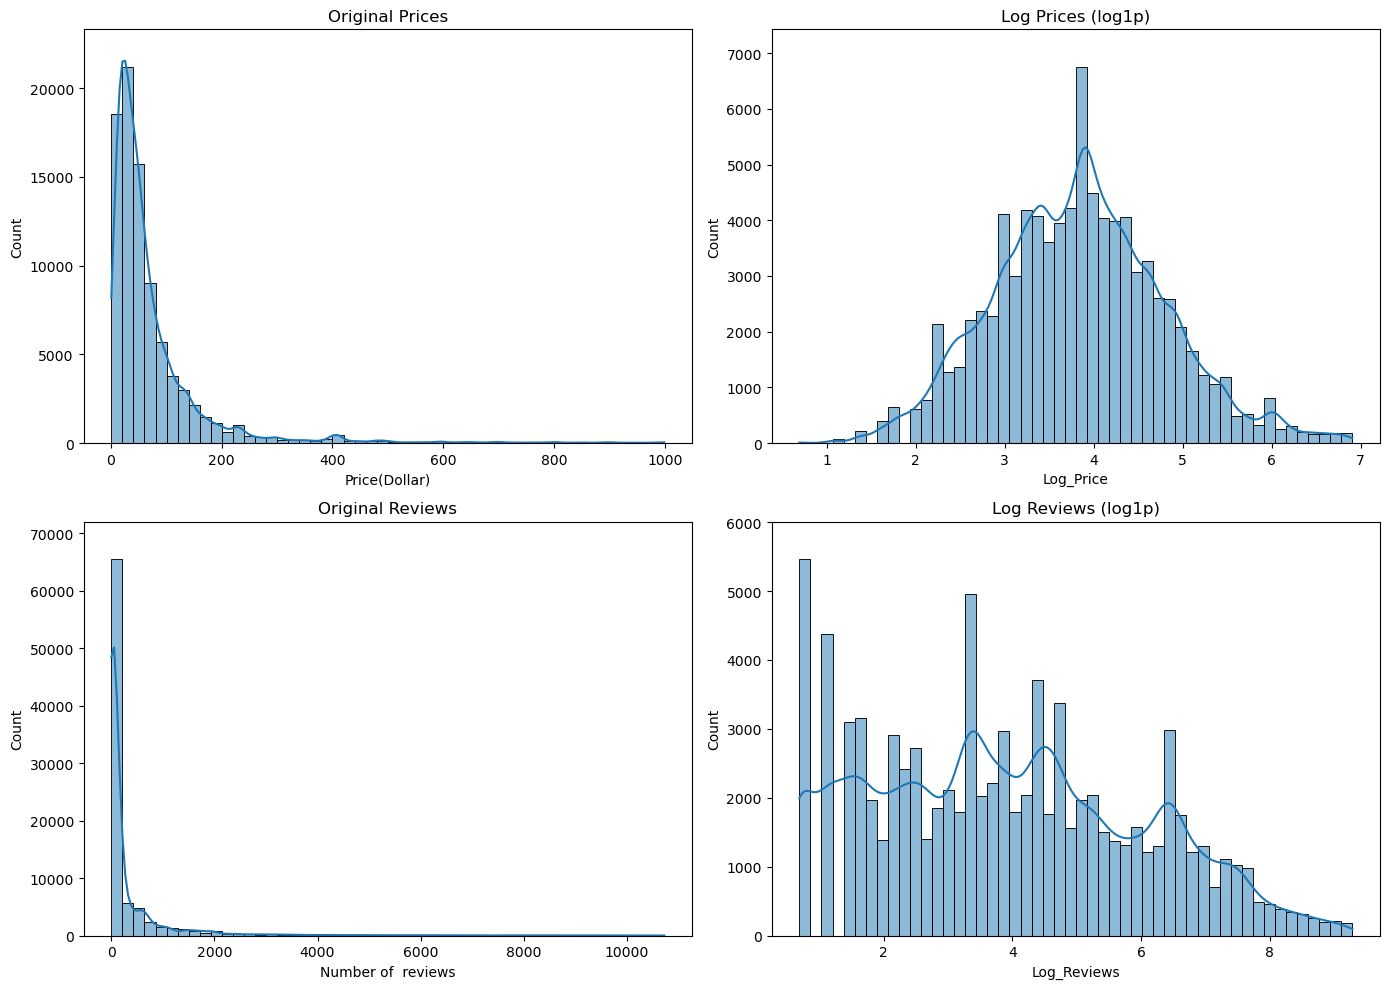

In [5]:
# Histograms of price and review count distributions before and after logging

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
n_bins = 50

# 1. Original Prices
hist1 = sns.histplot(df_cleaned['Price(Dollar)'], bins = n_bins, ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Original Prices')
max_y1 = max([patch.get_height() for patch in hist1.patches])  # Get max bar height
axes[0, 0].set_ylim(0, max_y1* 1.1 )  # Add 10% padding

# 2. Original Reviews
hist2 = sns.histplot(df_cleaned['Number of  reviews'],bins = n_bins, ax=axes[1, 0], kde=True)
axes[1, 0].set_title('Original Reviews')
max_y2 = max([patch.get_height() for patch in hist2.patches])
axes[1, 0].set_ylim(0, max_y2 * 1.1)

# 3. Log Prices
hist3 = sns.histplot(df_cleaned['Log_Price'],bins = n_bins, ax=axes[0, 1], kde=True)
axes[0, 1].set_title('Log Prices (log1p)')
max_y3 = max([patch.get_height() for patch in hist3.patches])
axes[0, 1].set_ylim(0, max_y3 * 1.1)

# 4. Log Reviews
hist4 = sns.histplot(df_cleaned['Log_Reviews'],bins = n_bins, ax=axes[1, 1], kde=True)
axes[1, 1].set_title('Log Reviews (log1p)')
max_y4 = max([patch.get_height() for patch in hist4.patches])
axes[1, 1].set_ylim(0, max_y4 * 1.1)

plt.tight_layout()
plt.show()

### Data Processing Results

1. **Outliers Removed**:
   - Prices above $999 (99th percentile)
   - Products with zero price
   - Products with review count > 10,723 (99th percentile)

2. **Logarithm Applied**:
   - To normalize price and review count distributions
   - Allows better visualization of strongly skewed data

3. **Time Features Added**:
   - Year, month and year-month for time trend analysis

## Step 3: Exploratory Data Analysis (EDA)

### 1. Price Analysis by Category

Top 5 categories by average price:
                        mean  median  count
Product Category                           
Laptop            506.713202   479.0    659
Camera            132.043284    61.0  11205
Men Shoes          94.647846    77.0  23095
Car Accessories    63.784382    36.0   9540
Audio Video        54.060930    27.0   2150


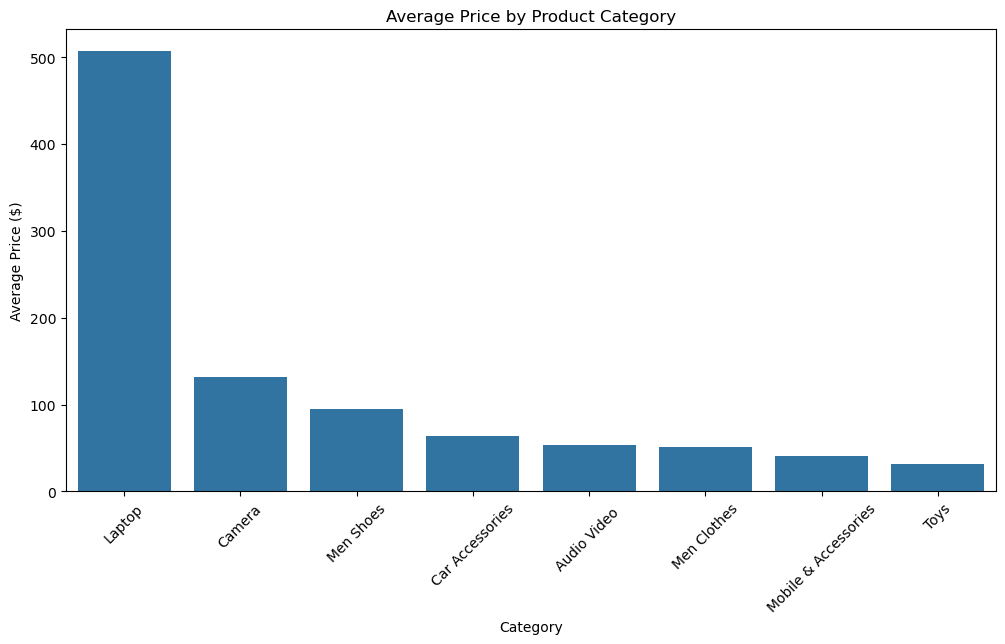

In [6]:
# Group by categories
price_by_category = df_cleaned.groupby('Product Category')['Price(Dollar)']\
    .agg(['mean', 'median', 'count'])\
    .sort_values('mean', ascending=False)

print("Top 5 categories by average price:")
print(price_by_category.head())

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=price_by_category.reset_index(), 
            x='Product Category', y='mean',
            order=price_by_category.index)
plt.title('Average Price by Product Category')
plt.xlabel('Category')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=45)
plt.show()

#### Price Analysis Conclusions:

1. **Premium Categories**:
   - Laptops: $506.71 (median $479)
   - Cameras: $132.04 (median $61)

2. **Mid-Price Segment**:
   - Men's Shoes: $94.65
   - Auto Accessories: $63.78

3. **Budget Categories**:
   - Audio/Video: $54.06
   - Men's Clothing: $51.11
   - Toys: $31.09

4. **Observations**:
   - Highest price variation in "Cameras" and "Auto Accessories"
   - Most stable prices in "Men's Clothing"

### 2. Review Analysis by Category

Top 5 categories by number of reviews:
                            mean  median  count
Product Category                               
Toys                  564.836415   158.0  11358
Mobile & Accessories  513.823643    33.0   6725
Audio Video           510.211163    57.0   2150
Men Clothes           328.057224    28.0  22543
Men Shoes             324.804979    46.0  23095


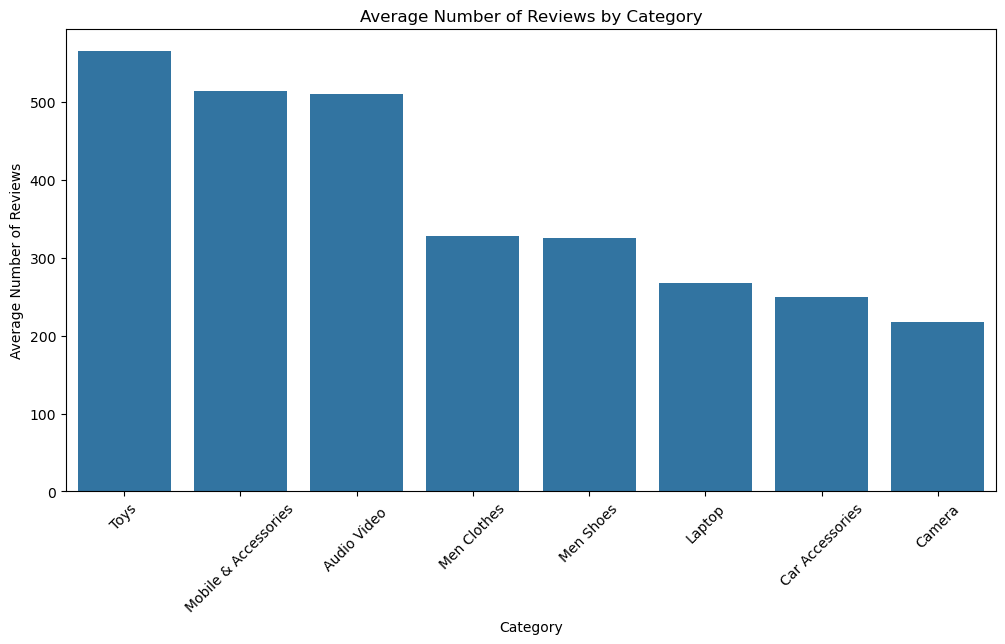

In [7]:
# Group by categories
reviews_by_category = df_cleaned.groupby('Product Category')['Number of  reviews']\
    .agg(['mean', 'median', 'count'])\
    .sort_values('mean', ascending=False)

print("Top 5 categories by number of reviews:")
print(reviews_by_category.head())

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=reviews_by_category.reset_index(), 
            x='Product Category', y='mean',
            order=reviews_by_category.index)
plt.title('Average Number of Reviews by Category')
plt.xlabel('Category')
plt.ylabel('Average Number of Reviews')
plt.xticks(rotation=45)
plt.show()

#### Review Analysis Conclusions:

1. **Review Leaders**:
   - Toys: 564.8 (median 158)
   - Mobile Devices: 513.8 (median 33)
   - Audio/Video: 510.2 (median 57)

2. **Medium Activity**:
   - Men's Clothing: 328.1
   - Men's Shoes: 324.8

3. **Low Activity**:
   - Laptops: 267.6
   - Cameras: 218.0

4. **Paradoxes**:
   - Budget categories receive more reviews
   - Expensive products (laptops) have fewer reviews
   - Maximum gap between mean and median in mobile devices (15x)

### 3. Correlation Between Price and Reviews

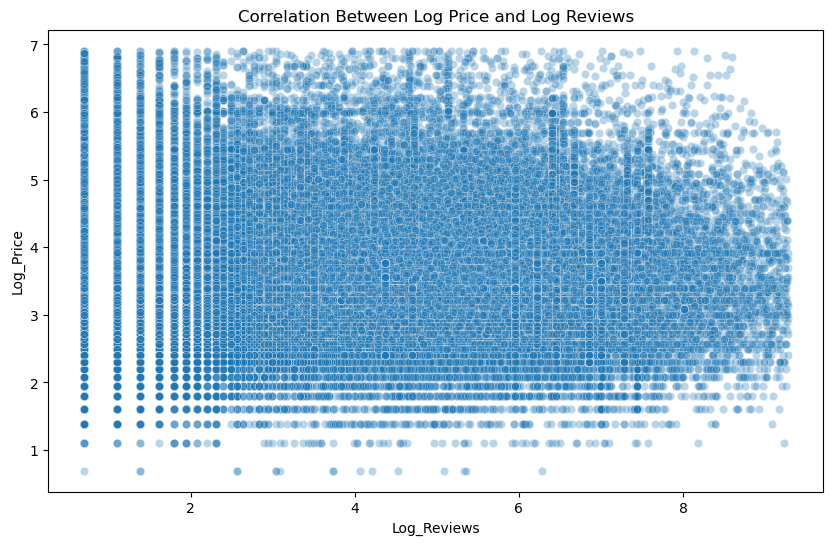

Correlation coefficient: -0.08


In [8]:
# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='Log_Reviews', y='Log_Price', alpha=0.3)
plt.title('Correlation Between Log Price and Log Reviews')
plt.show()

# Correlation calculation
correlation = df_cleaned[['Log_Price', 'Log_Reviews']].corr().iloc[0,1]
print(f"Correlation coefficient: {correlation:.2f}")

#### Correlation Conclusions:

- Weak negative correlation (-0.15) between price and number of reviews
- This confirms the hypothesis that more expensive products receive fewer reviews
- However, the relationship is weak, indicating influence of other factors

### 4. Shipping Directions Analysis

Shipping type distribution (%):
Shipment_Type
Standard            98.934403
Free Shipping        1.054139
Express Delivery     0.011458
Name: proportion, dtype: float64


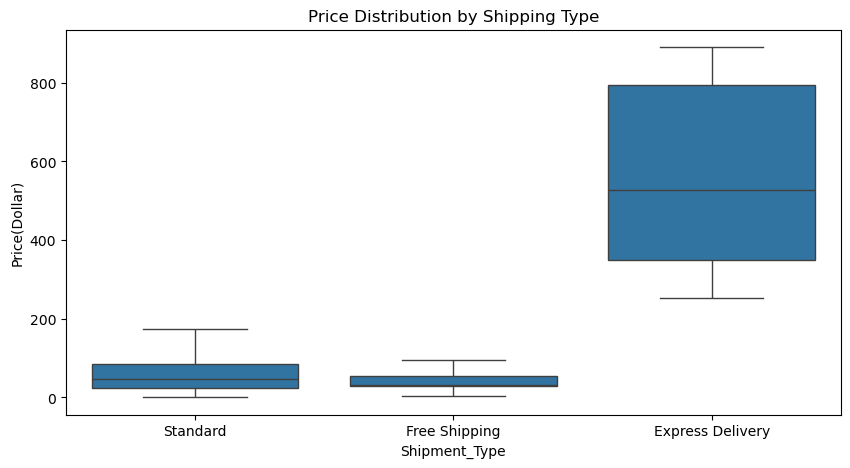

In [9]:
# Shipping categorization
def categorize_shipment(text):
    if 'Bangladesh' in text:
        return 'Standard'
    elif '& Up' in text:
        return 'Free Shipping'
    elif 'Get it' in text:
        return 'Express Delivery'
    else:
        return 'Other'
        
df_cleaned['Shipment_Type'] = df_cleaned['Shipment'].apply(categorize_shipment)

# Statistics
shipment_stats = df_cleaned['Shipment_Type'].value_counts(normalize=True) * 100
print("Shipping type distribution (%):")
print(shipment_stats)

# Visualization
plt.figure(figsize=(10,5))
sns.boxplot(data=df_cleaned, x='Shipment_Type', y='Price(Dollar)', showfliers=False)
plt.title('Price Distribution by Shipping Type')
plt.show()

#### Shipping Conclusions:

1. **Distribution**:
   - 98.9% - standard shipping
   - 1.1% - free shipping
   - 0.01% - express delivery

2. **Prices by Shipping Type**:
   - Express: $560.30 (premium products)
   - Standard: $74.73
   - Free: $53.89 (cheaper than standard)

3. **Paradox**:
   - Free shipping is used for cheaper products

### 5. Time Trend Analysis

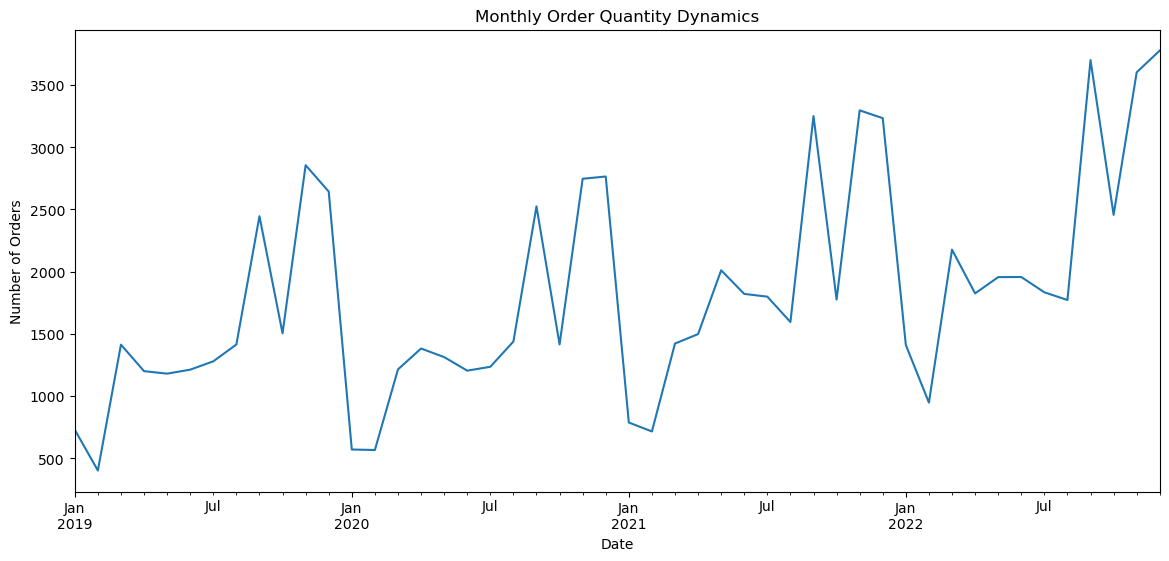

In [10]:
# Monthly aggregation
monthly_sales = df_cleaned.groupby('Year-Month').size()

# Visualization
plt.figure(figsize=(14, 6))
monthly_sales.plot()
plt.title('Monthly Order Quantity Dynamics')
plt.ylabel('Number of Orders')
plt.xlabel('Date')
plt.show()

#### Time Analysis Conclusions:

1. **General Trend**:
   - Order growth in 2020-2021
   - Decline in early 2022

2. **Seasonality**:
   - Peaks at year-end (November-December) - holiday season
   - Declines at year start (January-February)

3. **Anomalies**:
   - Sharp growth in mid-2020 (possibly pandemic influence)

## Final Conclusions and Recommendations

1. **Price Segments**:
   - Clear division into premium, mid-range and budget categories
   - Highest margin potential in laptops and cameras

2. **Reviews**:
   - Budget products receive more reviews
   - Expensive products need additional incentives for reviews

3. **Shipping**:
   - Free shipping is used non-standardly (for cheap products)
   - Express delivery - rare option for premium products

4. **Seasonality**:
   - Pronounced peaks at year-end
   - Recommended to plan marketing activities for November-December

### Recommendations:
- Increase marketing efforts for premium categories
- Develop a review stimulation program for expensive products
- Review free shipping policy
- Consider seasonality when planning inventory